In [1]:
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import roc_auc_score, roc_curve, auc, accuracy_score, confusion_matrix
from sklearn.metrics import make_scorer, recall_score, f1_score,precision_score

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

import xgboost as xgb
from xgboost import XGBClassifier

from imblearn.pipeline import make_pipeline
from imblearn.pipeline import Pipeline as imPipeline
from imblearn.over_sampling import SMOTE

from joblib import dump, load
import mlflow
import dagshub
import pickle
import shap
from lime.lime_tabular import LimeTabularExplainer

from my_utilities import custom_loss, custom_scorer

import evidently
from evidently import ColumnMapping

from evidently.report import Report
from evidently.metrics.base_metric import generate_column_metrics
from evidently.metric_preset import DataDriftPreset, TargetDriftPreset, DataQualityPreset, RegressionPreset
from evidently.metrics import ColumnSummaryMetric, ColumnQuantileMetric, ColumnDriftMetric
from evidently.metrics import *

from evidently.test_suite import TestSuite
from evidently.tests.base_test import generate_column_tests
from evidently.test_preset import DataStabilityTestPreset, NoTargetPerformanceTestPreset
from evidently.tests import *

c:\Users\arken\anaconda3\lib\site-packages\shap\utils\_clustering.py:35: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def _pt_shuffle_rec(i, indexes, index_mask, partition_tree, M, pos):
c:\Users\arken\anaconda3\lib\site-packages\shap\utils\_clustering.py:54: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  def delta_minimization_order(all_masks, max_swap_size=100

In [2]:
dagshub.init("Projet7", "alexandre", mlflow=True)

Repository initialized!

In [3]:
mlflow.set_tracking_uri("https://dagshub.com/alexandre/Projet7.mlflow")

In [4]:
mlflow.set_experiment("XGBoost1")

<Experiment: artifact_location='mlflow-artifacts:/c8310743be434893bddf7c1f2f63cc07', creation_time=1694099002367, experiment_id='3', last_update_time=1694099002367, lifecycle_stage='active', name='XGBoost1', tags={}>

In [5]:
# chargement de base de données
df = pd.read_csv("../Data/Processed/fichier_xgb.csv", index_col="SK_ID_CURR")

In [6]:
df.head()

,EXT_SOURCE_3,EXT_SOURCE_2,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_EDUCATION_TYPE_Higher education,OCCUPATION_TYPE_Core staff,FLAG_DOCUMENT_3,AMT_REQ_CREDIT_BUREAU_HOUR,CODE_GENDER,PAYMENT_RATE,TARGET
SK_ID_CURR,,,,,,,,,,,
100002,0.139376,0.262949,True,True,False,False,1,0.000000,0,0.060749,1.0
100003,0.509353,0.622246,False,False,True,True,1,0.000000,1,0.027598,0.0
100004,0.729567,0.555912,True,True,False,False,0,0.000000,0,0.050000,0.0
100006,0.509353,0.650442,True,True,False,False,1,0.005809,1,0.094941,0.0
100007,0.509353,0.322738,True,True,False,True,0,0.000000,0,0.042623,0.0


In [7]:
df = df.rename(columns={"EXT_SOURCE_3":"Source_3",
                        "EXT_SOURCE_2" : "Source_2",
                        "NAME_INCOME_TYPE_Working" : "Travail",
                        "NAME_EDUCATION_TYPE_Secondary / secondary special" : "Lycée",
                        "NAME_EDUCATION_TYPE_Higher education" : "Etudes Sup",
                        "OCCUPATION_TYPE_Core staff" : "Cadre",
                        "FLAG_DOCUMENT_3" : "Indic_doc 3",
                        "AMT_REQ_CREDIT_BUREAU_HOUR" : "Nb demandes/h",
                        "CODE_GENDER" : "Sexe",
                        "PAYMENT_RATE" : "Tx pay.",
                })

In [8]:
df.dtypes

Source_3         float64
Source_2         float64
Travail             bool
Lycée               bool
Etudes Sup          bool
Cadre               bool
Indic_doc 3        int64
Nb demandes/h    float64
Sexe               int64
Tx pay.          float64
TARGET           float64
dtype: object

In [9]:
df['Nb demandes/h'].unique()

array([0.        , 0.00580855, 1.        , 2.        , 3.        ,
       4.        ])

In [10]:
df = df[df['Nb demandes/h'].isin([0, 1, 2, 3, 4])]


In [11]:
df.head()

,Source_3,Source_2,Travail,Lycée,Etudes Sup,Cadre,Indic_doc 3,Nb demandes/h,Sexe,Tx pay.,TARGET
SK_ID_CURR,,,,,,,,,,,
100002,0.139376,0.262949,True,True,False,False,1,0.0,0,0.060749,1.0
100003,0.509353,0.622246,False,False,True,True,1,0.0,1,0.027598,0.0
100004,0.729567,0.555912,True,True,False,False,0,0.0,0,0.050000,0.0
100007,0.509353,0.322738,True,True,False,True,0,0.0,0,0.042623,0.0
100008,0.621226,0.354225,False,True,False,False,1,0.0,0,0.056101,0.0


In [12]:
# Définir la fonction de perte personnalisée
def custom_loss(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    fn_weight = 10.0  # poids pour les faux négatifs
    fp_weight = 10.0  # poids pour les faux positifs
    return cm[0, 1] * fp_weight + cm[1, 0] * fn_weight

In [13]:
# Faire une fonction d'évaluation personnalisée pour GridSearch
custom_scorer = make_scorer(custom_loss, greater_is_better=False)

In [14]:
# Séparer les données d'entraînement et de test
train_test_data = df.dropna(subset=["TARGET"])
X = train_test_data.drop(columns=["TARGET"])
y = train_test_data["TARGET"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [15]:
# Combinez X_train et y_train en un seul dataframe
train_df = pd.concat([X_train, y_train], axis=1)
train_df.to_csv('../Data/Processed/train_data.csv', index=True)
train_df.to_csv('train_data.csv', index=True)
combine1 = pd.read_csv('train_data.csv', index_col="SK_ID_CURR")

test_df = pd.concat([X_test, y_test], axis=1)
test_df.to_csv('../Data/Processed/test_data.csv', index=True)
test_df.to_csv('test_data.csv', index=True)
combine2 = pd.read_csv('test_data.csv', index_col="SK_ID_CURR")

complet = df.dropna(subset=["TARGET"])
complet.to_csv("complet_data.csv", index=True)

In [16]:
train_df.head()

,Source_3,Source_2,Travail,Lycée,Etudes Sup,Cadre,Indic_doc 3,Nb demandes/h,Sexe,Tx pay.,TARGET
SK_ID_CURR,,,,,,,,,,,
150842,0.509353,0.582794,False,False,True,True,1,0.0,1,0.026636,0.0
161872,0.538863,0.646389,False,False,True,False,0,0.0,1,0.042627,0.0
401408,0.643026,0.463107,True,True,False,False,1,0.0,1,0.067100,0.0
326840,0.772631,0.544559,True,True,False,False,1,0.0,1,0.053279,0.0
282274,0.499272,0.566021,True,False,True,True,0,0.0,1,0.027675,0.0


In [17]:
complet.head()

,Source_3,Source_2,Travail,Lycée,Etudes Sup,Cadre,Indic_doc 3,Nb demandes/h,Sexe,Tx pay.,TARGET
SK_ID_CURR,,,,,,,,,,,
100002,0.139376,0.262949,True,True,False,False,1,0.0,0,0.060749,1.0
100003,0.509353,0.622246,False,False,True,True,1,0.0,1,0.027598,0.0
100004,0.729567,0.555912,True,True,False,False,0,0.0,0,0.050000,0.0
100007,0.509353,0.322738,True,True,False,True,0,0.0,0,0.042623,0.0
100008,0.621226,0.354225,False,True,False,False,1,0.0,0,0.056101,0.0


In [18]:
# Initialiser le DummyClassifier
dummy_clf = DummyClassifier(
    strategy="most_frequent"
)  

dummy_clf.fit(X_train, y_train)

y_pred_dummy = dummy_clf.predict(X_test)

roc_auc_dummy = roc_auc_score(y_test, y_pred_dummy)
accuracy_dummy = accuracy_score(y_test, y_pred_dummy)
cm_dummy = confusion_matrix(y_test, y_pred_dummy)

path_cm_dummy = "Divers/confusion_matrix_dummy.txt"
with open(path_cm_dummy, "w") as f:
    f.write(str(cm_dummy))

with mlflow.start_run(run_name="Dummy") as run:
    
    mlflow.log_metric("roc_auc_dummy", roc_auc_dummy)
    mlflow.log_metric("accuracy", accuracy_dummy)

    mlflow.log_artifact(path_cm_dummy)

    mlflow.sklearn.log_model(dummy_clf, "dummy_model")

Setuptools is replacing distutils.


In [19]:
print("ROC AUC =", roc_auc_dummy)
print("ACCURACY =", accuracy_dummy)
print(cm_dummy)

ROC AUC = 0.5
ACCURACY = 0.9207384707939313
[[48975     0]
 [ 4216     0]]


In [20]:
# Instancier le modèle XGBoost
model_xgb_opti = xgb.XGBClassifier()

# Création du pipeline
pipeline = imPipeline([("smote", SMOTE()), ("xgb", model_xgb_opti)])

# Paramètres à tester
param_grid = {
    "xgb__max_depth": [3, 5, 7],
    "xgb__learning_rate": [0.1, 0.01],
    "xgb__n_estimators": [50, 100, 150, 200],
}

# Création du GridSearch
grid_search_xgb_opti = GridSearchCV(
    estimator=pipeline, param_grid=param_grid, scoring=custom_scorer, cv=3, n_jobs=-1
)

# Adapter le modèle
grid_search_xgb_opti.fit(X_train, y_train)

# Prédire sur l'ensemble de test
y_pred = grid_search_xgb_opti.predict(X_test)

best_model0 = grid_search_xgb_opti.best_estimator_
best_model0

Pipeline(steps=[('smote', SMOTE()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=200,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [21]:
roc_auc0 = roc_auc_score(y_test, y_pred)
accuracy0 = accuracy_score(y_test, y_pred)
score_matrix0 = custom_loss(y_test, y_pred)
print(f"ROC AUC Score: {roc_auc0*100:.2f}%")
print(f"ACCURACY: {accuracy0*100:.2f}%")
print(f"SCORE MATRICE: {score_matrix0}")

ROC AUC Score: 61.65%
ACCURACY: 81.07%
SCORE MATRICE: 100670.0


In [22]:
# Instancier le modèle XGBoost
model_xgb_opti = xgb.XGBClassifier()

# Création du pipeline
pipeline = imPipeline([("smote", SMOTE()), ("xgb", model_xgb_opti)])

# Paramètres à tester
param_grid = {
    "xgb__max_depth": [7],
    "xgb__learning_rate": [0.1],
    "xgb__n_estimators": [200],
}

# Création du GridSearch
grid_search_xgb_opti = GridSearchCV(
    estimator=pipeline, param_grid=param_grid, scoring=custom_scorer, cv=3, n_jobs=-1
)

# Adapter le modèle
grid_search_xgb_opti.fit(X_train, y_train)

# Prédire sur l'ensemble de test
y_pred = grid_search_xgb_opti.predict(X_test)
best_model = grid_search_xgb_opti.best_estimator_

In [23]:
# Obtenir le meilleur modèle après le GridSearch
best_model = grid_search_xgb_opti.best_estimator_
best_model

Pipeline(steps=[('smote', SMOTE()),
                ('xgb',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, gpu_id=None,
                               grow_policy=None, importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=7, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, n_estimators=200,
                               n_jobs=None, num_parallel_tree=None,
                               predictor=None, random_state=None, ...))])

In [24]:
path_cm_xgb = "Divers/confusion_matrix_xgb.txt"
cmxgb = confusion_matrix(y_test, y_pred)

# Enregistrer la matrice de confusion sous forme de texte
with open(path_cm_xgb, "w") as f:
    f.write(str(cmxgb))

with mlflow.start_run(run_name="XGB") as run:

    roc_auc = roc_auc_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    score_matrix = custom_loss(y_test, y_pred)

    # Enregistrement des métriques dans MLflow
    mlflow.log_metric("ROC AUC Score", roc_auc)
    mlflow.log_metric("ACCURACY", accuracy)
    mlflow.log_metric("SCORE MATRIX", score_matrix)

    # Enregistrer la matrice de confusion sous forme de texte
    mlflow.log_artifact(path_cm_xgb)

    # Enregistrer les paramètres
    mlflow.log_params({"max_depth": 7, "learning_rate": 0.1, "n_estimators": 200})

    # Enregistrer le modèle
    mlflow.sklearn.log_model(grid_search_xgb_opti.best_estimator_, "best_model")

In [25]:
print(f"ROC AUC Score: {roc_auc*100:.2f}%")
print(f"ACCURACY: {accuracy*100:.2f}%")
print(f"Confusion Matrix: {cmxgb}")
print(f"SCORE MATRICE: {score_matrix}")

ROC AUC Score: 61.36%
ACCURACY: 81.29%
Confusion Matrix: [[41652  7323]
 [ 2628  1588]]
SCORE MATRICE: 99510.0


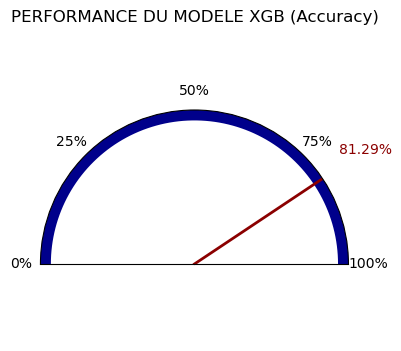

In [26]:
def draw_gauge(accuracy_score):
    # Normaliser le score entre 0 et 1
    normalized_score = accuracy_score

    # Créer un axe polar
    fig, ax = plt.subplots(figsize=(4, 4), subplot_kw={"polar": True})

    # Dessiner l'arc de la jauge (demi-cercle supérieur)
    arc = np.linspace(0, np.pi, 100)
    r = np.full(100, 0.6)
    ax.plot(arc, r, color="darkblue", linewidth=15)

    # Calculer l'angle pour l'aiguille
    theta = np.pi * (normalized_score)
    ax.plot([theta, theta], [0, 0.6], color='darkred', linewidth=2)

    # Marquer le score sur l'aiguille
    ax.text(theta , 0.8, f"{accuracy_score * 100:.2f}%", color='darkred', ha="center", va="center")

    # Configurer les angles et étiquettes en pourcentage
    ax.set_theta_zero_location("W")
    ax.set_theta_direction(-1)
    ax.set_xticks(np.radians([0, 45, 90, 135, 180]))
    ax.set_xticklabels(["0%", "25%", "50%", "75%", "100%"])

    # Supprimer les rayons et les étiquettes radiales
    ax.set_yticks([])
    ax.set_yticklabels([])

    # Supprimer les lignes radiales
    ax.grid(False)

    # Réduire la vue au demi-cercle
    ax.set_ylim([0, 0.6])
    ax.set_xlim([0, np.pi])

    ax.set_title("PERFORMANCE DU MODELE XGB (Accuracy)", va="bottom")

    plt.show()

    fig.savefig("Divers/jauge_xgb.png")

accuracy_value = accuracy
draw_gauge(accuracy_value)

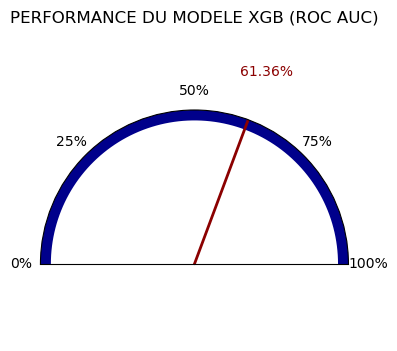

In [27]:
def draw_gauge(accuracy_score):
    if not np.isscalar(accuracy_score):
        raise ValueError("La valeur fournie à 'draw_gauge' doit être un scalaire.")

    # Normaliser le score entre 0 et 1
    normalized_score = accuracy_score

    # Créer un axe polar
    fig, ax = plt.subplots(figsize=(4, 4), subplot_kw={"polar": True})

    # Dessiner l'arc de la jauge (demi-cercle supérieur)
    arc = np.linspace(0, np.pi, 100)
    r = np.full(100, 0.6)
    ax.plot(arc, r, color="darkblue", linewidth=15)

    # Calculer l'angle pour l'aiguille
    theta = np.pi * (normalized_score)
    ax.plot([theta, theta], [0, 0.6], color='darkred', linewidth=2)

    # Marquer le score sur l'aiguille
    ax.text(theta , 0.8, f"{accuracy_score * 100:.2f}%", color='darkred', ha="center", va="center")

    # Configurer les angles et étiquettes en pourcentage
    ax.set_theta_zero_location("W")
    ax.set_theta_direction(-1)
    ax.set_xticks(np.radians([0, 45, 90, 135, 180]))
    ax.set_xticklabels(["0%", "25%", "50%", "75%", "100%"])

    # Supprimer les rayons et les étiquettes radiales
    ax.set_yticks([])
    ax.set_yticklabels([])

    # Supprimer les lignes radiales
    ax.grid(False)

    # Réduire la vue au demi-cercle
    ax.set_ylim([0, 0.6])
    ax.set_xlim([0, np.pi])

    ax.set_title("PERFORMANCE DU MODELE XGB (ROC AUC)", va="bottom")

    plt.show()

    fig.savefig("Divers/jauge_xgb_auc.png")

accuracy_value = roc_auc
draw_gauge(accuracy_value)

In [28]:
y_pred_proba = grid_search_xgb_opti.predict_proba(X_test)[:, 1]

# Calculer la courbe ROC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

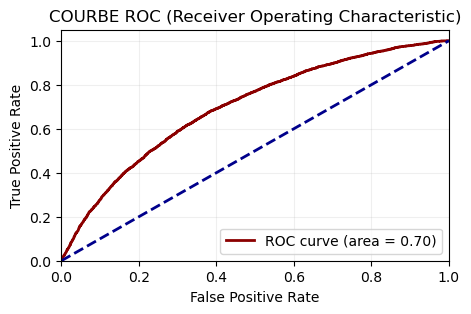

In [29]:
# Créer la figure et l'axe
fig, ax = plt.subplots(figsize=(5, 3))

# Tracer la courbe ROC sur l'axe
ax.plot(fpr, tpr, color='darkred', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
ax.plot([0, 1], [0, 1], color='darkblue', lw=2, linestyle='--')  # ligne diagonale pour un modèle aléatoire
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('COURBE ROC (Receiver Operating Characteristic)')
ax.legend(loc="lower right")
ax.grid(alpha=0.2)
plt.show()

# Sauvegarder la figure
fig.savefig("Divers/courbe_roc.png")

In [30]:
mlflow.end_run()

In [31]:
# Enregistrer le modèle et les variables associées avec joblib
file_path = "../projet7_git/xgb_model.joblib"
data_to_save = {
    "model": grid_search_xgb_opti,
    "roc_auc": roc_auc,
    "confusion_matrix": cmxgb
}

dump(data_to_save, file_path)

print("Modèle XGBoost et variables enregistrés avec succès.")

Modèle XGBoost et variables enregistrés avec succès.


In [32]:
complet.head()

,Source_3,Source_2,Travail,Lycée,Etudes Sup,Cadre,Indic_doc 3,Nb demandes/h,Sexe,Tx pay.,TARGET
SK_ID_CURR,,,,,,,,,,,
100002,0.139376,0.262949,True,True,False,False,1,0.0,0,0.060749,1.0
100003,0.509353,0.622246,False,False,True,True,1,0.0,1,0.027598,0.0
100004,0.729567,0.555912,True,True,False,False,0,0.0,0,0.050000,0.0
100007,0.509353,0.322738,True,True,False,True,0,0.0,0,0.042623,0.0
100008,0.621226,0.354225,False,True,False,False,1,0.0,0,0.056101,0.0


In [33]:
complet.columns

Index(['Source_3', 'Source_2', 'Travail', 'Lycée', 'Etudes Sup', 'Cadre',
       'Indic_doc 3', 'Nb demandes/h', 'Sexe', 'Tx pay.', 'TARGET'],
      dtype='object')

In [34]:
sample_data = {
    "Source_3": 0.15,  
    "Source_2": 0.27,
    "Travail": 1,  
    "Lycée": 1, 
    "Etudes Sup": 0,
    "Cadre": 0,
    "Indic_doc 3": 1,  
    "Nb demandes/h": 0.0, 
    "Sexe": 0, 
    "Tx pay.": 0.065,  
}

In [35]:
# Création du DataFrame avec les données d'exemple
sample_df = pd.DataFrame([sample_data])

# Utilisation du modèle pour faire des prédictions
prediction = grid_search_xgb_opti.predict(sample_df)
print(prediction)

[1]


In [36]:
# Création du DataFrame avec les données d'exemple
sample_df = pd.DataFrame([sample_data])

# Utilisation du modèle pour obtenir les probabilités de classe
probabilities = grid_search_xgb_opti.predict_proba(sample_df)

# Probabilité de la classe 1 (assumant que 1 est la classe positive)
probability_of_class_1 = probabilities[0][1]

# Affichage de la probabilité de la classe 1 en pourcentage
print(f"Probabilité de la classe 1 : {probability_of_class_1 * 100:.2f}%")

Probabilité de la classe 1 : 86.12%


In [37]:
# Faite un tableau pour trouver le seuil adapté
y_probs = grid_search_xgb_opti.predict_proba(X_test)[:, 1]

thresholds = np.linspace(0, 1, 50)  # test 50 seuils entre 0 et 1
results = []

for threshold in thresholds:
    y_pred = [1 if prob >= threshold else 0 for prob in y_probs]
    accuracy = accuracy_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    
    results.append({
        'Threshold': threshold,
        'Accuracy': accuracy,
        'Recall': recall,
        'Precision': precision,
        'F1 Score': f1,
        'True Positives': tp,
        'False Positives': fp,
        'True Negatives': tn,
        'False Negatives': fn
    })

# Transformez les résultats en un DataFrame pour une analyse facile
results_df = pd.DataFrame(results)

Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.


In [38]:
results_df

,Threshold,Accuracy,Recall,Precision,F1 Score,True Positives,False Positives,True Negatives,False Negatives
0,0.000000,0.079262,1.000000,0.079262,0.146881,4216,48975,0,0
1,0.020408,0.091012,0.999288,0.080156,0.148408,4213,48347,628,3
2,0.040816,0.122803,0.991935,0.082311,0.152009,4182,46625,2350,34
3,0.061224,0.167340,0.978178,0.085344,0.156991,4124,44198,4777,92
4,0.081633,0.218270,0.960389,0.089061,0.163007,4049,41414,7561,167
5,0.102041,0.271644,0.937144,0.093122,0.169411,3951,38477,10498,265
6,0.122449,0.323607,0.911528,0.097419,0.176026,3843,35605,13370,373
7,0.142857,0.372300,0.884725,0.101824,0.182628,3730,32902,16073,486
8,0.163265,0.418548,0.854127,0.106180,0.188880,3601,30313,18662,615
9,0.183673,0.458160,0.822581,0.109952,0.193976,3468,28073,20902,748


In [39]:
results_df.loc[35]

Threshold              0.714286
Accuracy               0.896167
Recall                 0.124763
Precision              0.222976
F1 Score               0.160000
True Positives       526.000000
False Positives     1833.000000
True Negatives     47142.000000
False Negatives     3690.000000
Name: 35, dtype: float64

Le seuil sera donc à 70%.

In [40]:
# Obtenez les probabilités de la classe positive
probabilities = grid_search_xgb_opti.predict_proba(sample_df)[:, 1]

In [41]:
def draw_client(accuracy_score):
    if not np.isscalar(accuracy_score):
        raise ValueError("La valeur fournie à 'draw_gauge' doit être un scalaire.")

    # Normaliser le score entre 0 et 1
    normalized_score = accuracy_score

    # Créer un axe polar
    fig, ax = plt.subplots(figsize=(4, 4), subplot_kw={"polar": True})

    # Dessiner l'arc de la jauge pour la plage de 0 à 70% (en rouge)
    arc_red = np.linspace(0, 0.7 * np.pi, 100)
    r_red = np.full(100, 0.6)
    ax.plot(arc_red, r_red, color="red", linewidth=15)

    # Dessiner l'arc de la jauge pour la plage de 70 à 100% (en bleu)
    arc_blue = np.linspace(0.7 * np.pi, np.pi, 100)
    r_blue = np.full(100, 0.6)
    ax.plot(arc_blue, r_blue, color="darkblue", linewidth=15)

    # Calculer l'angle pour l'aiguille
    theta = np.pi * (normalized_score)
    needle, = ax.plot([theta, theta], [0, 0.6], color='darkred', linewidth=2)

    # Configurer les angles et étiquettes en pourcentage
    ax.set_theta_zero_location("W")
    ax.set_theta_direction(-1)
    ax.set_xticks(np.radians([0, 45, 90, 126, 135, 180]))
    ax.set_xticklabels(["0%", "25%", "50%","70%", "75%", "100%"])

    # Supprimer les rayons et les étiquettes radiales
    ax.set_yticks([])
    ax.set_yticklabels([])

    # Supprimer les lignes radiales
    ax.grid(False)

    # Réduire la vue au demi-cercle
    ax.set_ylim([0, 0.6])
    ax.set_xlim([0, np.pi])

    ax.set_title("EVALUATION DU CLIENT", va="bottom")

    # Ajouter le score en tant que légende
    ax.legend([needle], [f'Score = {accuracy_score * 100:.2f}%'])

    plt.show()

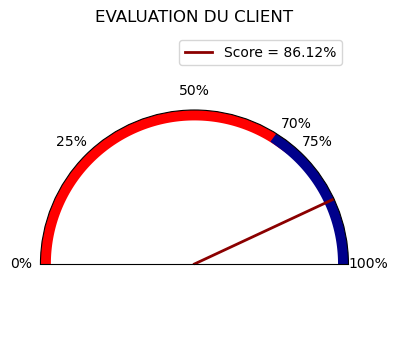

In [42]:
sample_probability = probabilities[0]
draw_client(sample_probability)

In [43]:
print(probabilities)

[0.8611546]


LIME/SHAP

In [44]:
sample_data = {
    "Source_3": 0.15,  
    "Source_2": 0.27,
    "Travail": 1,  
    "Lycée": 1, 
    "Etudes Sup": 0,
    "Cadre": 0,
    "Indic_doc 3": 1,  
    "Nb demandes/h": 0.0, 
    "Sexe": 0, 
    "Tx pay.": 0.065,  
}

In [45]:
# Récupération du meilleur estimateur XGBoost du GridSearch
best_xgb_model = grid_search_xgb_opti.best_estimator_['xgb']

In [46]:
# 1. Initialiser l'explainer
explainer = LimeTabularExplainer(training_data = X_train.values,
                                 feature_names = X_train.columns,
                                 class_names = ["Not Default", "Default"],
                                 mode = 'classification')

# 2. Expliquer la prédiction de `sample_data`
exp = explainer.explain_instance(np.array(pd.DataFrame([sample_data]).iloc[0]), best_xgb_model.predict_proba, num_features=10)

# 3. Visualiser l'explication
exp.show_in_notebook()


In [47]:
# Charger le modèle et les variables associées
file_path = "../projet7_git/xgb_model.joblib"
loaded_data = load(file_path)
loaded_model = loaded_data["model"]

In [48]:
# Création d'un DataFrame pour la prédiction
sample_df = pd.DataFrame([sample_data])

# Effectuer la prédiction
sample_prediction = loaded_model.predict(sample_df)
print(f"La prédiction pour sample_data est: {sample_prediction[0]}")

# Calcul de la probabilité
sample_proba = loaded_model.predict_proba(sample_df)
print(f"La probabilité que sample_data appartienne à la classe 1 est: {sample_proba[0][1]:.2f}")

La prédiction pour sample_data est: 1
La probabilité que sample_data appartienne à la classe 1 est: 0.86


In [49]:
loaded_data = load('xgb_model.joblib')
print(type(loaded_data))


<class 'dict'>


In [50]:
model = loaded_data['model']

best_params = None

# Vérifier si 'best_params_' est un attribut du modèle
if hasattr(model, 'best_params_'):
    best_params = model.best_params_

print(best_params)

{'xgb__learning_rate': 0.1, 'xgb__max_depth': 7, 'xgb__n_estimators': 200}


In [51]:
# Étape 0 : Charger le modèle et obtenir le meilleur estimateur XGB
model = loaded_data['model']

xgb_model = model.best_estimator_['xgb']

# Étape 1 : Initialiser le Explainer avec le modèle XGB
explainer = shap.Explainer(xgb_model)

# Étape 2 : Obtenir les valeurs SHAP pour sample_data
shap_values = explainer.shap_values(pd.DataFrame([sample_data]))

# Étape 3 : Visualiser l'explication
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[0], pd.DataFrame([sample_data]))


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


ntree_limit is deprecated, use `iteration_range` or model slicing instead.
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


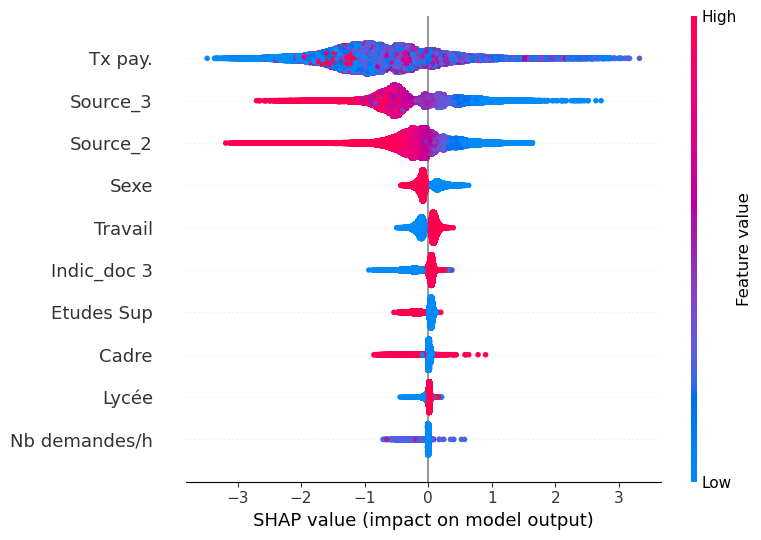

In [52]:
import io

# Création d'une "fausse" sortie fichier pour capturer le plot
buf = io.BytesIO()

model = loaded_data['model']
xgb_model = model.best_estimator_['xgb']
explainer = shap.Explainer(xgb_model)
shap_values = explainer.shap_values(X_train)

# Utiliser cette sortie pour la sauvegarde
plt.figure()
shap.summary_plot(shap_values, X_train)
plt.tight_layout()
plt.savefig(buf, format="png")
buf.seek(0)

# Enregistrement de l'image depuis la sortie "fausse"
with open("shap_explanation.png", "wb") as f:
    f.write(buf.getvalue())

plt.close()

In [53]:
df.dtypes

Source_3         float64
Source_2         float64
Travail             bool
Lycée               bool
Etudes Sup          bool
Cadre               bool
Indic_doc 3        int64
Nb demandes/h    float64
Sexe               int64
Tx pay.          float64
TARGET           float64
dtype: object

In [54]:
import pandas as pd
test_final = pd.read_csv('test_data.csv', index_col="SK_ID_CURR")
test_final.tail(10)

,Source_3,Source_2,Travail,Lycée,Etudes Sup,Cadre,Indic_doc 3,Nb demandes/h,Sexe,Tx pay.,TARGET
SK_ID_CURR,,,,,,,,,,,
148482,0.349055,0.685916,True,True,False,False,1,0.0,0,0.037582,0.0
213126,0.324891,0.630511,False,False,True,False,1,0.0,1,0.072766,0.0
416760,0.509353,0.346733,True,True,False,False,1,0.0,1,0.029314,0.0
400668,0.771362,0.419146,False,True,False,False,1,0.0,1,0.048636,0.0
232749,0.468660,0.104530,True,True,False,False,1,0.0,1,0.067960,1.0
190391,0.401407,0.129402,True,True,False,False,0,0.0,0,0.059542,0.0
422328,0.751724,0.645804,False,False,True,False,1,0.0,1,0.027582,0.0
279404,0.782608,0.419184,True,True,False,False,1,0.0,0,0.054448,0.0
234244,0.352340,0.731001,True,False,True,False,0,0.0,0,0.048921,0.0


In [55]:
import pandas as pd
test_final = pd.read_csv('complet_data.csv', index_col = "SK_ID_CURR")
test_final.head(5)

,Source_3,Source_2,Travail,Lycée,Etudes Sup,Cadre,Indic_doc 3,Nb demandes/h,Sexe,Tx pay.,TARGET
SK_ID_CURR,,,,,,,,,,,
100002,0.139376,0.262949,True,True,False,False,1,0.0,0,0.060749,1.0
100003,0.509353,0.622246,False,False,True,True,1,0.0,1,0.027598,0.0
100004,0.729567,0.555912,True,True,False,False,0,0.0,0,0.050000,0.0
100007,0.509353,0.322738,True,True,False,True,0,0.0,0,0.042623,0.0
100008,0.621226,0.354225,False,True,False,False,1,0.0,0,0.056101,0.0
